# loss function

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import sys

sys.path.append('D:/Learning/Project/QA/version1/')


```
交叉熵的理解：   
这里的交叉熵的输入是这个样子的：  
下边的loss里边：
上边是真实的标签（处理成了onehot的形式），比如这里你输入的标签字典就三个词：我爱你，那么这里的`[1., 0., 0.]`代表的就是“我”；`[0., 1., 0.]`：“爱”； `[0., 0., 1.]`：“你” 

下边就是通过神经网络之后经过softmax之后的输出的概率分布的结果，通过这两个部分来计算交叉熵
```

In [2]:
cce = tf.keras.losses.CategoricalCrossentropy()
loss = cce(
  [[1., 0., 0.], [0., 1., 0.], [0., 0., 1.]],
  [[.9, .05, .05], [.05, .89, .06], [.05, .01, .94]])
print('Loss: ', loss.numpy()) 

Loss:  0.09458993


```
下边的这种交叉熵叫做稀疏矩阵的分类交叉熵
它的输入也是一个标签，但是它输入的标签和上边的不太一样[o, 1, 2],没有经过onehot处理，这个[o, 1, 2]就是你建立的vocab里边的index，这里只需要将这个index输入进来就ok了
```

In [3]:
sce = tf.keras.losses.SparseCategoricalCrossentropy()
loss = sce(
  tf.convert_to_tensor([0, 1, 2]),
  tf.convert_to_tensor([[.9, .05, .05], [.05, .89, .06], [.05, .01, .94]]))
print('Loss: ', loss.numpy())  # Loss: 0.3239


Loss:  0.09458992


In [6]:
# sce = tf.keras.losses.SparseCategoricalCrossentropy()
# loss = sce(
#   [0, 1, 2],
#   [[.9, .05, .05], [.05, .89, .06], [.05, .01, .94]])
# print('Loss: ', loss.numpy())  # Loss: 0.3239

In [5]:
help(tf.keras.losses.SparseCategoricalCrossentropy)

Help on class SparseCategoricalCrossentropy in module tensorflow.python.keras.losses:

class SparseCategoricalCrossentropy(LossFunctionWrapper)
 |  SparseCategoricalCrossentropy(from_logits=False, reduction='auto', name='sparse_categorical_crossentropy')
 |  
 |  Computes the crossentropy loss between the labels and predictions.
 |  
 |  Use this crossentropy loss function when there are two or more label classes.
 |  We expect labels to be provided as integers. If you want to provide labels
 |  using `one-hot` representation, please use `CategoricalCrossentropy` loss.
 |  There should be `# classes` floating point values per feature for `y_pred`
 |  and a single floating point value per feature for `y_true`.
 |  
 |  In the snippet below, there is a single floating point value per example for
 |  `y_true` and `# classes` floating pointing values per example for `y_pred`.
 |  The shape of `y_true` is `[batch_size]` and the shape of `y_pred` is
 |  `[batch_size, num_classes]`.
 |  
 |  

优化器optimizer

In [7]:
# 优化器调用api
optimizer = tf.keras.optimizers.Adagrad(params['learning_rate'],
                                        initial_accumulator_value=params['adagrad_init_acc'],
                                        clipnorm=params['max_grad_norm'])
# clipnorm = : 梯度裁剪，当梯度较大的时候要设置这样的一个值，只不过这里是一个范数的形式
# 工作中对于很多的参数都是有经验值的，自己不断的实验，不断的调的话效果不一定好，还比较费时间

loss函数

In [ ]:
# loss调用api
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [10]:
real_label = [1, 0, 0]
result = tf.math.equal(real_label, 1)  # 这个逻辑下是统计为1的个数   等于1的为True，不等于1的为False
result

<tf.Tensor: shape=(3,), dtype=bool, numpy=array([ True, False, False])>

In [11]:
reverse_result = tf.math.logical_not(result)  # 这里进行了一个逻辑求反，是为了统计为0的个数
reverse_result

<tf.Tensor: shape=(3,), dtype=bool, numpy=array([False,  True,  True])>

In [13]:
reverse_result_cast = tf.cast(reverse_result, dtype=tf.float32)
print(reverse_result_cast)
tf.reduce_sum(reverse_result_cast, axis=-1).numpy()
# 这里为什么要进行反转之后再求1的个数呢？
# 因为是要计算输出的长度，输出的长度部分是没有被mask的部分，所以要计算没有mask部分的长度，所以这里将没有mask的部分转为1进行计算长度

tf.Tensor([0. 1. 1.], shape=(3,), dtype=float32)


2.0

## 定义loss函数---------重点部分

In [ ]:
# 定义loss函数  （重点部分！！！！）  如果实在不明白就记住
def loss_function(real, pred):
    # 判断logit为1和0的数量   涉及mask的时候通常都是0/1的问题，这里主要是在Report里边有的词扣掉了，是空的，要把它找出来
    # 在mask过程中，被mask的为1，没有被mask的为0，所以这里要统计被mask的部分
    # 这里代码的意思就是传进来真实的标签，看一下里边有多少个为0，有多少个为1,然后放到一个逻辑判断里边
    # 代码过程解析见上边
    mask = tf.math.logical_not(tf.math.equal(real, 1))  # 判断真实标签是否为1，为1的话就是空值mask，然后进行转换
    # 再一个就是这里到底是0还是1？？？！！！  可以看下一篇的loss函数，看填充的值是什么这里就写什么，填0就写0，填<PAD>就写<PAD>
    # 这里将被mask的部分由原来的的用1表示转换为用0表示，用来将下边计算loss的时候将这部分的loss计算去掉
    print(mask.numpy)  # 整个模型搭建完成后，可以逐步的打印看看，具体的内容是什么。
    # 计算decoder的长度  即输出的Report的结果  结果的长度是什么样的
    # mask原来都是bool类型(True/False),转换为浮点型
    dec_lens = tf.reduce_sum(tf.cast(mask, dtype=tf.float32), axis=-1)
    # 计算loss值  这里之所以要进行前边的两步是为了看看是否有空的摘要，要是没有就直接进行loss计算就可以了
    loss_ = loss_object(real, pred)
    # 转换mask的格式，转化成loss的一个格式，这里要用来乘以loss，目的就是为了把空摘要去掉，就是没有词的这样的地方
    # 这里给的真实的标签也就是Report，有的地方是空的，这里的mask主要是用来找那个空的地方
    mask = tf.cast(mask, dtype=loss_.dtype)
    # 调整loss  就相当于把缺词的地方就删掉了  loss对应的是每一个输出也就是每一个词有一个loss
    loss_ *= mask
    # 确认下是否有空的摘要别加入计算
    # 因为把其中的空的部分删掉了，所以这里进行了一个求和然后求平均
    loss_ = tf.reduce_sum(loss_, axis=-1) / dec_lens
    return tf.reduce_mean(loss_)

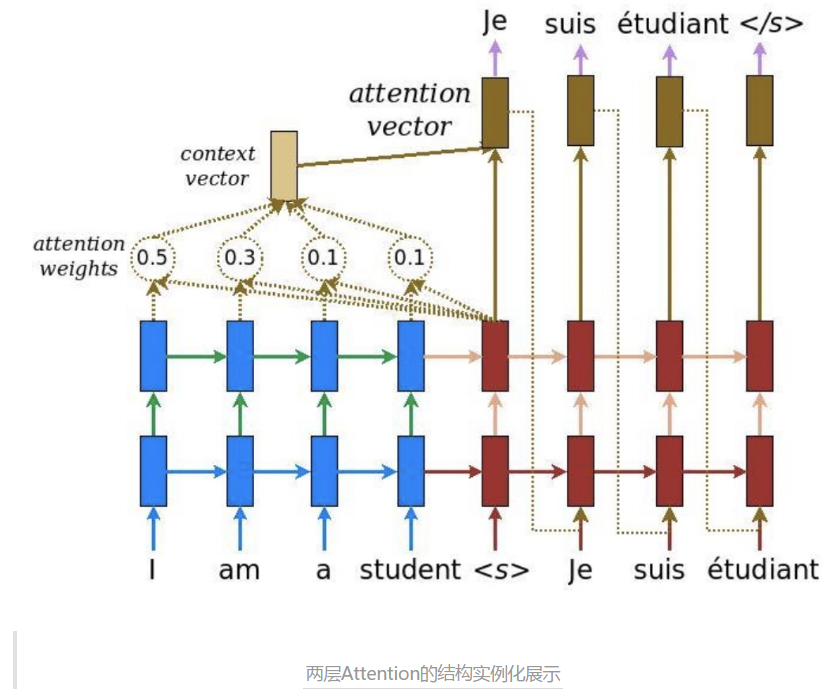


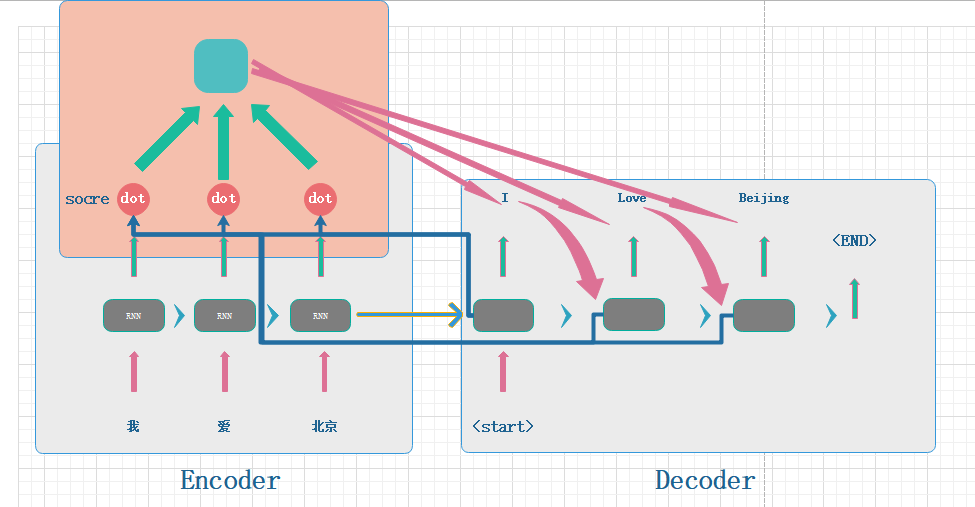


In [14]:
# 维度增加的例子

a = tf.zeros([1, 2])
a

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0., 0.]], dtype=float32)>

In [15]:
b = tf.expand_dims(a, 1)
b

<tf.Tensor: shape=(1, 1, 2), dtype=float32, numpy=array([[[0., 0.]]], dtype=float32)>

## 建立train-step   训练的过程是什么样子的

In [ ]:
# 对类进行实例化，对于类来说实例化的时候，是定义模型，导入的参数就是初始化函数__init__的参数
# 这里主要是词表的大小，词向量的维度，encoder单元数，batch_size的大小
encoder = Encoder(vocab_size, embedding_dim, enc_units, batch_sz)

In [ ]:
@tf.function  # tensorflow的新的功能，加一个装饰器，下边的编程方式就完全是Python的编程方式
def train_step(inp, targ, enc_hidden):
    # 这一部分也十分的重要！！！！！！，加上上一个重要的部分，搞定了训练的部分就结束了
    # 这里的参数是：input target encoder_hidden层
    # 初始化loss，一开始没有计算的时候，loss就是0，要初始化
    loss = 0

    with tf.GradientTape() as tape:
        # 这个环境下的好处是，每一步都可以拿到对应该步的梯度值，也就是求导值
        # 这里的encoder是上边实例化好的encoder，也就是定义好了，这里再传进去参数就是定义的类中的执行
        # 部分了，也就是call部分，对应的也要传进该部分的参数，这里接收的输出，也就是执行部分的输出
        enc_output, enc_hidden = encoder(inp, enc_hidden)  # gru的输出
        # 这里的两步就实现了在我们建立的Encoder层中输入数据，拿出结果
        # Encoder层结束之后就要进行Decoder了

        dec_hidden = enc_hidden  # 这里decoder的输入就是encoder的输出，即enc_hidden
        # 这里的思路就是在Encoder里边把它处理成这样的hidden状态，然后再decoder中将这种状态解码出来，
        # 进行预测输出
        # 确定decoder的输入
        # 这里的输入是一个特殊的符号，这里命名叫啥都行，就是在建立字典的时候命名好，
        # 这里传入字典，调用一个查索引的函数
        # 这里要乘以一个BATCH_SIZE，因为一次传进去的是一个batch_size
        # 这里的1就是增加维度的方向，也就是在哪一个维度上进行增加
        # 这里输入的内容就是在原来的字典中找到<start>这个输入，这个矩阵的长度肯定是batch_size的长度
        # 运行的时候打印一下，具体的看看
        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)
        # 增维的作用是为了进行下一步的计算，到时候还是打印看看，不增维会出错
        
        # 这里拿到输入之后再怎么进行呢？接下来就是直接循环的一个一个的进行计算，循环的长度就是你真正
        # 目标的长度，进行一个单词一个单词的预测

        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
            # passing enc_output to the decoder
            # 实例化decoder层，参数是decoder的输入(x)，decoder的隐藏层(hidden)，和encoder的输出
            # 这里得到的输出是预测的值（softmax的概率分布输出），decoder隐藏层的状态变量，
            # 以及一个用不到的输出
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            # 这里就得到了第一个词的输出结果了，即已经得到了图中紫色箭头的softmax输出了，接下来要求loss了
            
            # 前边已经初始化loss了，这里直接调用loss函数，循环求出预测每个值的loss，累加loss的结果即可
            # loss函数的输入参数real和prediction，上边传进来的targ,是训练集中的真实标签，是一串词
            # 这一串词里边要的是已经预测过的部分对应的词，和这一步要预测的词
            loss += loss_function(targ[:, t], predictions)
            # 这里在预测第二个词的时候，要将预测第一个值的结果传进来

            # using teacher forcing  缺点：泛化能力差，可以查论文，看提升的方法。
            # 因为要将前边预测结果也输入进来，所以要增加维度，因为当前在预测第t个，所以要将第t前边的传进来
            # 这里的input在第一个循环的时候用的是<start>,第二个循环开始用的就是targ,真实的训练结果
            # 也就是说，在预测第二个的时候不是将第一个预测结果传给第二个，而是将第一个的真实值传给了
            # 第二个，因为第一个的预测结果可能是错的，会影响第二个的预测，这就是teacher forcing
            # 就是老师在教你
            dec_input = tf.expand_dims(targ[:, t], 1)
            # 到这里基本就是整个训练的过程

    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

## Teacher Forcing：  
RNN模型是用前一步的输出作为输入（真实标签作为输出）  
teacher forcing方法能够解决收敛的速度慢和不稳定的问题  


一个target：[START] Mary had a little lamb [END]  
这里第一个输入是[START]  
输出：$\hat{y}$:  这里预测的输出可能是任何的值，不一定是Mary，但是使用teacher forcing时，不管预测的结果是什么，都一定会将对应的标签值，如传到第二个的时候，一定是将Mary传进去  

针对于Teacher Forcing的问题，有什么解决方法呢？
方式一：beam search
如果这里设置的beam=3，那么这里第一个$\hat{y}$得到的预测值就是三个值，如Mary, a, had,在进行第二个值预测的时候，就直接将这些得到的预测值，全部作为下一个的输入，提高预测准准确率（如果这里将得到的三个值做一个计算，计算一下每一个词与真实标签的loss，选择损失最小的往下传递是否可以？？）  

方式二：curriculum Learning,有对应的论文，可以研究一下


test

# evaluate

In [ ]:
def evaluate(sentence):
    # 这里的最终的结果应该是我输出一个文本或者一个对话，这里输出一个Report
    # 这里输入的是一个句子（sentence）
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    # 要输入一个句子就要对这个句子进行处理
    # 怎么处理呢？
    # 也是要进行第一遍的过程，要切词，切完词把这些词的索引查出来，拿到这个输入，然后进一步对这个句子进行 
    # 调整，比如句子不够长了进行一个调整，padding一下等，但是这里的处理都是一些简单的API，真正复杂的
    # 句子里边这样是完全不够的，最终的目的就是要拿到一个全是索引的一个输入
    # 处理句子，放进词表（vocab），然后再将句子处理成全是索引的形式，便于查找词，词向量
    
    sentence = preprocess_sentence(sentence)

    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_inp,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    # 获取encoder的输出
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        # 这里decoder输出最终的预测结果
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()
        
        # 这里直接读出䘝最大概率，最终得到的是预测的词的索引也就是它的ID
        predicted_id = tf.argmax(predictions[0]).numpy()
        
        # 因为是一个词一个词的输出，所以这里要把它们加到一个总的结果的list里边
        result += targ_lang.index_word[predicted_id] + ' '
        
        # 遇到<END>表示达到最大长度，就要结束
        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

# Layer and Model

pycharm

Model：
这里的Model比Layer多了这些功能：
Model.fit()
Model.evaluate()
Model.Predict()
...

通常创建类的时候继承Layer和Model都可以

# encoder

tensorflow2.0

In [ ]:
import tensorflow as tf
help(tf.keras.layers.Embedding)

对于这里的单向的双向的GRU自己去跑跑，不会跑的话，去找找别人怎么跑的

In [ ]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz, embeddings):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, weights= embeddings)
        # 这里最后一个参数设置是将训练好的embedding之间传进来，不然的话TensorFlow会自动训练，会减慢
        # 模型的训练速度浪费时间（查的文档中没有这个参数）
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        # 双向的GRU  做双向的时候要注意每一层的单元的数量
        self.bigru = tf.keras.layers.Bidirectional(self.gru, merge_mode='concat')

    def call(self, x, hidden):
        # 双向的计算也一样，先进行embedding
        # 输入的x就是index索引，通过这个索引去拿词向量
        x = self.embedding(x)
        # 做双向的首先要将传进来的hidden层切成一半
        hidden = tf.split(hidden, num_or_size_splits=2, axis=1)
        # 拿到前向后向的计算结果
        # 上边拿到的词向量在放入GRU中作为输入
        output, forward_state, backward_state = self.bigru(x, initial_state=hidden)
        # 进行一个concat操作，得到的单元数就变成了两倍了
        state = tf.concat([forward_state, backward_state], axis=1)
        # 这里如果是单向的GRU，就将上边的三行代码去掉，保留下边的这行
        # output, state = self.gru(x, initial_state=hidden)
        return state, output 
    
    def initialize_hidden_state(self):
        # 由于单元数变成两倍了，所以这里初始化的单元数也要乘以2，或者在前边设置enc_units是设置为原来的一半
        # 这里就不用乘以2了，比如将256设置为128
        return tf.zeros((self.batch_sz, 2*self.enc_units))

tensorflow2.0

In [ ]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        gpus = tf.config.experimental.list_physical_devices('GPU')
        if gpus:
            self.gru = tf.keras.layers.CuDNNGRU(self.enc_units,
                                                return_sequences=True,
                                                return_state=True,
                                                recurrent_initializer='glorot_uniform')
        else:
            self.gru = tf.keras.layers.GRU(self.enc_units,
                                           return_sequences=True,
                                           return_state=True,
                                           recurrent_initializer='glorot_uniform')
        # self.bigru = tf.keras.layers.Bidirectional(self.gru, merge_mode='concat')

    def call(self, x, hidden):
        # 输入的x就是index索引，通过这个索引去拿词向量
        x = self.embedding(x)
        # 上边拿到的词向量在放入GRU中作为输入
        # hidden = tf.split(hidden, num_or_size_splits=2, axis=1)
        # output, forward_state, backward_state = self.bigru(x, initial_state=hidden)
        # state = tf.concat([forward_state, backward_state], axis=1)
        output, state = self.gru(x, initial_state=hidden)
        # 在tensorflow中GRU 有两个输出，是相等的
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

# Attention

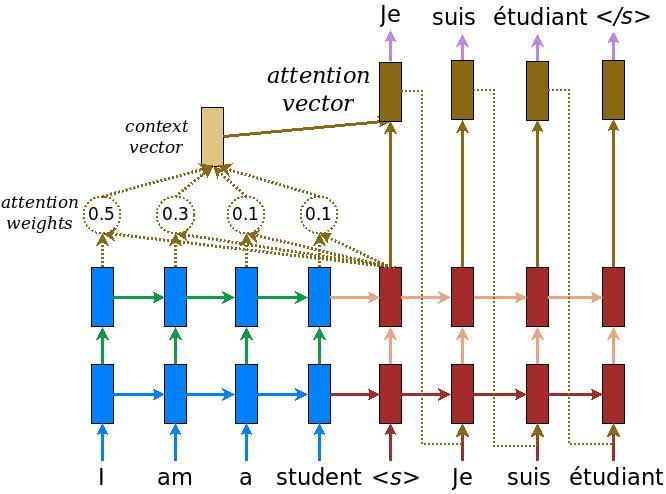



这里计算score 的方式有一下两种：  

$$\operatorname{score}\left(\boldsymbol{h}_{t}, \overline{\boldsymbol{h}}_{s}\right)=\left\{\begin{array}{ll}
\boldsymbol{h}_{t}^{\top} \boldsymbol{W} \overline{\boldsymbol{h}}_{s} & \text { [Luong's multiplicative style] } \\
\boldsymbol{v}_{a}^{\top} \tanh \left(\boldsymbol{W}_{1} \boldsymbol{h}_{t}+\boldsymbol{W}_{2} \overline{\boldsymbol{h}}_{s}\right) & \text { [Bahdanau's additive style] }
\end{array}\right.$$  

编码器采用 [Bahdanau](https://arxiv.org/pdf/1409.0473.pdf) 注意力，也就是第二种方法进行计算  



- FC = 完全连接（密集）层
- EO = 编码器输出
- H = 隐藏层状态
- X = 解码器输入

以及伪代码：

    score = FC(tanh(FC(EO) + FC(H)))
    # 下边的代码已经提前定义了这里的三个FC，分别是W1， W2，V
    attention weights = softmax(score, axis = 1)。 Softmax 默认被应用于最后一个轴，但是这里我们想将它应用于 第一个轴, 因为分数 （score） 的形状是 (批大小，最大长度，隐藏层大小)。最大长度 （max_length） 是我们的输入的长度。因为我们想为每个输入分配一个权重，所以 softmax 应该用在这个轴上。
    context vector = sum(attention weights * EO, axis = 1)。选择第一个轴的原因同上。
    embedding output = 解码器输入 X 通过一个嵌入层。
    merged vector = concat(embedding output, context vector)
    此合并后的向量随后被传送到 GRU


In [ ]:
class BahdanauAttention(tf.keras.Model):
    # other attention is LuongAttention
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        # 将W1 W2 V这些参数进行初始化，进行Dense层操作，定义好最终要划分成多少类
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):  # query = decoder_hidden_output, values = encoder_output
        # attention的实际操作中有一个q, v，这里的q和v分别代表的是，解码器每个单元隐藏层的输出(query)和编码器的输出(values)
        # 运行的时候查看一下这里为什么需要一个增维的处理，更好的来理解
        # hidden shape == (batch_size, hidden_size) 增维后：
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)  # 是增加了时间步的维度吗
        hidden_with_time_axis = tf.expand_dims(query, 1)

        # 这里的score求的就是图中0.4,0.3，...的分数
        # 分数的形状 == （批大小，最大长度，1）
        # 我们在最后一个轴上得到 1， 因为我们把分数应用于 self.V
        # 在应用 self.V 之前，张量的形状是（批大小，最大长度，单位）
        score = self.V(tf.nn.tanh(self.W1(values) + self.W2(hidden_with_time_axis)))
        # 这个式子中的hidden的值就是

        # 注意力权重 （attention_weights） 的形状 == （批大小，最大长度，1）
        # 对score进行求softmax，得到注意力权重
        attention_weights = tf.nn.softmax(score, axis=1)

        # 上下文向量 （context_vector） 求和之后的形状 == （批大小，隐藏层大小）
        # 使用注意力权重乘以encoder输出的状态变量
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

# decoder

In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        # 对于decoder，一开始的时候的初始化是和encoder基本一样的
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        # 就是这里多了一个全连接层，多带上了一个softmax，进行分类的大小就是词典的大小
        self.fc = tf.keras.layers.Dense(vocab_size)

        # used for attention
        # 进行一个Attention的初始化：将上边的Attention层拿下来进行实例化
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        # 上边实例化之后这里进行计算
        # 首先拿到Attention的输出结果
        # 编码器输出 （enc_output） 的形状 == （批大小，最大长度，隐藏层大小）
        context_vector, attention_weights = self.attention(hidden, enc_output)
        # 上边定义的Attention在这里也就拿到使用，作为进行decoder的一个输入

        # x 在通过嵌入层后的形状 == （批大小，1，嵌入维度）
        # decoder的输入，先进行词向量的一个embedding
        x = self.embedding(x)

        # x 在拼接 （concatenation） 后的形状 == （批大小，1，嵌入维度 + 隐藏层大小）
        # 合并后得到最终的输入
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # 将合并后的向量传送到 GRU
        output, state = self.gru(x)

        # 输出的形状 == （批大小 * 1，隐藏层大小）
        output = tf.reshape(output, (-1, output.shape[2]))

        # 输出的形状 == （批大小，vocab）
        x = self.fc(output)

        return x, state, attention_weights

# 完整的encoder-attention-decoder

```
如果想把encoder，decoder，attention之间的数据传递，维度变化，数值计算这一些列的东西都搞明白，就要将这张图和下边的程序相结合，一点点的将细节的部分打印出来，对照着图一点点的分析，就可以弄清楚
```

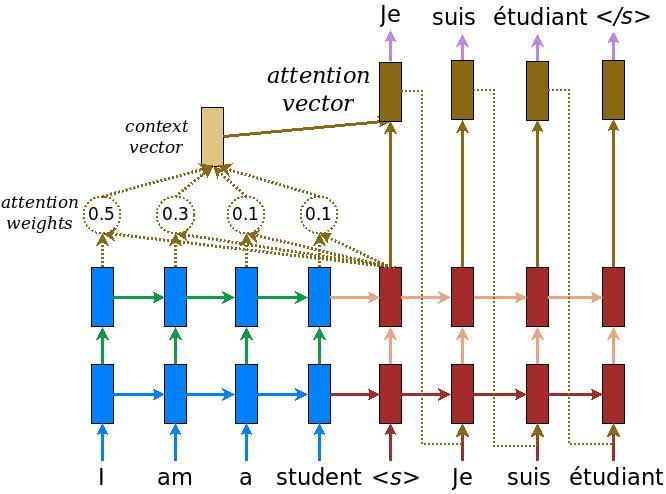

In [17]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional
from tensorflow.keras.layers import Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy
import tensorflow as tf
from utils.gpu_utils import config_gpu


class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        """
        构建Encoder  因为是构建框架，所以这个初始化函数没有返回值
        :param vocab_size: 词表的大小 总共有多少个词
        :param embedding_dim: 每一个词使用多少维的向量
        :param embedding_matrix: 预处理好的词向量矩阵    这个参数可以不设置，让模型自己训练，比较耗时
        :param enc_units: encoder的单元个数
        :param batch_sz: 一次传入的batch的大小  即一次传入多少个句子
        """
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size,
                                                   embedding_dim,
                                                   trainable=False)  # 设置模型不进行词向量训练
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        """
        Encoder层的前向传播的过程--Forward
        :param x: Encoder层的输入
        :param hidden: GRU层的隐藏层状态
        :return: 返回Encoder层的输出，GRU层的隐藏层状态的输出
        """
        # 输入数据经过embedding层
        print('Encoder的输入：\n {}'.format(x))
        x = self.embedding(x)
        print('Encoder的输入的index经过embedding之后的结果：\n', x)
        # 经过隐藏层，维度由(64, 88)变为了：(64, 88, 256)
        # embedding层的输出进入gru层，得到Encoder层的输出和GRU层隐藏层状态的输出
        output, state = self.gru(x, initial_state=hidden)
        return output, state

    def initialize_hidden_state(self):
        """
        初始化编码过程中GRU隐藏层状态
        :return: 编码过程中GRU隐藏层的初始化状态
        """
        return tf.zeros(shape=(self.batch_sz, self.enc_units))


class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        """
        搭建注意力层的框架
        :param units: 注意力层的单元个数，通常和Encoder层，Decoder层相同
        """
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        """
        注意力层的前向传播的过程
        :param query: GRU单元隐藏层状态的输出
        :param values: 编码器(Encoder)的编码结果输出(enc_output)
        :return: 上下文向量：context_vector, 注意力权重：attention_weights
        """
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # 这样做是为了执行加法以计算分数
        print('扩维前的解码器隐藏层的维度：\n {}'.format(query.shape))
        print('扩维前的解码器隐藏层的内容：\n {}'.format(query))
        hidden_with_time_axis = tf.expand_dims(query, 1)
        print('扩维后的解码器隐藏层的维度：\n {}'.format(hidden_with_time_axis.shape))

        # 分数的形状 == （批大小，最大长度，1）
        # 我们在最后一个轴上得到 1， 因为我们把分数应用于 self.V  ?
        # 在应用 self.V 之前，张量的形状是（批大小，最大长度，units）
        score = self.V(tf.nn.tanh(self.W1(values) + self.W2(hidden_with_time_axis)))
        print('通过q,v计算得到的分数：\n', score)

        # axis=1: 在max_len的维度上，计算的是每一个词的注意力权重
        # 最大长度 （max_length） 是我们的输入的长度。因为我们想为每个输入分配一个权重，所以softmax应该用在这个轴上。
        # 注意力权重 （attention_weights） 的形状 == （批大小，最大长度，1）
        attention_weights = tf.nn.softmax(score, axis=1)

        # 上下文向量 （context_vector） 求和之后的形状 == （批大小，隐藏层大小）
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights


class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        """
        构建Decoder框架
        :param vocab_size: 词表的大小
        :param embedding_dim: 使用多少维的向量表示一个词
        :param embedding_matrix: 预训练好的词向量
        :param dec_units:  Decoder层的单元数
        :param batch_sz: 一个batch的大小
        """
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size,
                                                   embedding_dim,
                                                   trainable=False)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        # self.fc = tf.keras.layers.Dropout(0.5)
        self.fc = tf.keras.layers.Dense(vocab_size)
        # self.fc = tf.keras.layers.Dense(vocab_size, activation=tf.keras.activations.softmax)

    def call(self, x, hidden, enc_output, context_vector):
        """
        Decoder层的前向传播过程，一个实现预测的过程
        :param x: Decoder层的输入
        :param hidden: Decoder中上一个时间步的隐藏层状态的输出
        :param enc_output:
        :param context_vector:
        :return:
        """
        # 使用上一个时间步的隐藏层（第一次使用编码器隐藏层）、编码器输出计算注意力权重
        # context_vector, attention_weights = self.attention(hidden, enc_output)

        # x 在通过嵌入层后的形状 == （批大小，1，嵌入维度）
        x = self.embedding(x)

        # 将上一时间步的预测结果跟注意力权重值结合在一起作为本次的GRU网络输入
        # x 在拼接 （concatenation） 后的形状 == （批大小，1，嵌入维度 + 隐藏层大小）
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # 将合并后的向量传送到 GRU
        output, state = self.gru(x)

        # 输出的形状 == （批大小 * 1，隐藏层大小）
        output = tf.reshape(output, (-1, output.shape[2]))

        # 输出的形状 == （批大小，vocab）
        prediction = self.fc(output)

        return prediction, state


if __name__ == '__main__':
    config_gpu()
    
    encoder = Encoder(vocab_size=25216, embedding_dim=256, enc_units=1024, batch_sz=64)
    sample_hidden = encoder.initialize_hidden_state()
    example_input_batch = tf.ones(shape=(64, 88), dtype=tf.float32)
    sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
    print('Encoder output shape: (batch_size, sequence_length, units) \n {}'.format(sample_output.shape))
    print('Encoder Hidden state shape: (batch size, units) \n {}'.format(sample_hidden.shape))

    attention_layer = BahdanauAttention(128)
    attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

    print("Attention result shape: (batch size, units) \n {}".format(attention_result.shape))
    print("Attention weights shape: (batch_size, sequence_length, 1) \n {}".format(attention_weights.shape))

    decoder = Decoder(vocab_size=25216, embedding_dim=256, dec_units=1024, batch_sz=64)
    sample_decoder_output, _, = decoder(tf.random.uniform((64, 1)),
                                        sample_hidden, sample_output, attention_result)

    print('Decoder output shape: (batch_size, vocab size) \n {}'.format(sample_decoder_output.shape))
    
   

1 Physical GPUs, 1 Logical GPUs
Encoder的输入：
 [[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
Encoder的输入的index经过embedding之后的结果：
 tf.Tensor(
[[[0.02372069 0.04326261 0.03293368 ... 0.01563844 0.02958945 0.00882598]
  [0.02372069 0.04326261 0.03293368 ... 0.01563844 0.02958945 0.00882598]
  [0.02372069 0.04326261 0.03293368 ... 0.01563844 0.02958945 0.00882598]
  ...
  [0.02372069 0.04326261 0.03293368 ... 0.01563844 0.02958945 0.00882598]
  [0.02372069 0.04326261 0.03293368 ... 0.01563844 0.02958945 0.00882598]
  [0.02372069 0.04326261 0.03293368 ... 0.01563844 0.02958945 0.00882598]]

 [[0.02372069 0.04326261 0.03293368 ... 0.01563844 0.02958945 0.00882598]
  [0.02372069 0.04326261 0.03293368 ... 0.01563844 0.02958945 0.00882598]
  [0.02372069 0.04326261 0.03293368 ... 0.01563844 0.02958945 0.00882598]
  ...
  [0.02372069 0.04326261 0.03293368 ... 0.01563844 0.02958945 0.00882598]

# seq2seq完整过程--基于翻译任务

对于使用seq2seq进行什么任务的问题很好理解：
如果encoder输入为中文，  
decoder输出为英文，那么这就是翻译任务  
decoder输出为中文，但是字数少很多的时候就是摘要  
decoder输出为中文，字数不固定可能是对话  

模型是通用的只是做的问题不一样

In [32]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time
import pandas as pd

assert tf.__version__.startswith('2.')
import sys

sys.path.append('D:/Learning/Project/QA/version1/')

None


In [21]:
# 重要模块：GPU自适应训练
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [22]:
import warnings
warnings.filterwarnings('ignore')

In [23]:
help(warnings.filterwarnings)

Help on function filterwarnings in module warnings:

filterwarnings(action, message='', category=<class 'Warning'>, module='', lineno=0, append=False)
    Insert an entry into the list of warnings filters (at the front).
    
    'action' -- one of "error", "ignore", "always", "default", "module",
                or "once"
    'message' -- a regex that the warning message must match
    'category' -- a class that the warning must be a subclass of
    'module' -- a regex that the module name must match
    'lineno' -- an integer line number, 0 matches all warnings
    'append' -- if true, append to the list of filters



In [24]:
# 判断是否有GPU
tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [25]:
# 判断是否有GPU
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 数据处理

In [26]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def preprocess_sentence_english(w):
    # 对句子进行预处理
    w = unicode_to_ascii(w.lower().strip())

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    w = w.rstrip().strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w
  
def preprocess_sentence_hindi(w):
    w = unicode_to_ascii(w.strip())

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    # w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    w = w.rstrip().strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w

## 加载数据集

In [33]:
import os
import pathlib  

# 获取项目根目录
root = pathlib.Path(os.path.abspath('__file__')).parent.parent
# 这里的parent的数量控制上一级和下一级

# 定义具体的路径
translate_data_path = os.path.join(root, 'data', 'Hindi_English_Truncated_Corpus.csv')
data = pd.read_csv(translate_data_path)
data.head(3)

,source,english_sentence,hindi_sentence
0,ted,politicians do not have permission to do what ...,"राजनीतिज्ञों के पास जो कार्य करना चाहिए, वह कर..."
1,ted,"I'd like to tell you about one such child,",मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहू...
2,indic2012,This percentage is even greater than the perce...,यह प्रतिशत भारत में हिन्दुओं प्रतिशत से अधिक है।


## 数据分析

In [34]:
print(data['english_sentence'].count())
print(data['hindi_sentence'].count())

127605
127607


In [35]:
data = data[data['english_sentence'].map(type) == str]
data = data[data['hindi_sentence'].map(type) == str]
data = data[data['english_sentence'].map(len) > 0]
data = data[data['hindi_sentence'].map(len) > 0]

print(data['english_sentence'].count())
print(data['hindi_sentence'].count())
# 将数据集处理成相同长度
# 处理数据集的时候一定要看看有没有Report，有的就没有一定要注意

127605
127605


In [36]:
data["token_size_en"] = data["english_sentence"].apply(lambda x: len(x.split(' ')))
data["token_size_hn"] = data["hindi_sentence"].apply(lambda x: len(x.split(' ')))
data = data.loc[data['token_size_hn'] < 22].copy()
# 这里只是导入了小于一定长度的数据

In [37]:
int(data['english_sentence'].count())
print(data['hindi_sentence'].count())
# 只是留下来九万多条数据

90799


In [38]:
# 对训练集进行处理
data['english_sentence'] = data['english_sentence'].apply(preprocess_sentence_english)
data['hindi_sentence'] = data['hindi_sentence'].apply(preprocess_sentence_hindi)

In [39]:
data.head()
# 这里的输出后边多出了输入单词个数，和输出单词个数

,source,english_sentence,hindi_sentence,token_size_en,token_size_hn
0,ted,<start> politicians do not have permission to ...,"<start> राजनीतिजञो क पास जो कारय करना चाहिए , ...",12,14
1,ted,<start> i d like to tell you about one such ch...,<start> मई आपको ऐस ही एक बचच क बार म बताना चाह...,9,11
2,indic2012,<start> this percentage is even greater than t...,<start> यह परतिशत भारत म हिनदओ परतिशत स अधिक ह...,10,9
3,ted,<start> what we really mean is that they re ba...,<start> हम य नही कहना चाहत कि वो धयान नही द पा...,12,11
4,indic2012,<start> . the ending portion of these vedas is...,<start> इनही वदो का अतिम भाग उपनिषद कहलाता ह। ...,9,8


In [40]:
en = data['english_sentence'].values.tolist()
hn = data['hindi_sentence'].values.tolist()

In [41]:
len(en),len(hn)

(90799, 90799)

In [42]:
en[-1],hn[-1]
# 这里查看一下最后一条数据，看一下是什么样子的

('<start> they ve just won four government contracts to build off their ambulances , <end>',
 '<start> हाल ही म उनह सरकारी ठका मिला ह करीब सौ नई अमबलनस बनान का , <end>')

In [43]:
def max_length(tensor): return max(len(t) for t in tensor)

In [44]:
def tokenize(lang):
    # 这里进行的是将上边处理好的句子转换成vocab索引，便于后面加载词向量，这里用的是keras里边
    # 高阶API的功能，不建议使用这些，有别的写法，后边课程会有，自己也去查
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    lang_tokenizer.fit_on_texts(lang)

    tensor = lang_tokenizer.texts_to_sequences(lang)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, lang_tokenizer

In [46]:
def load_dataset(num_examples):
    # 读数据，这里拿了少量的样本数量进行训练，这里通过设置num_examples的大小来设置选取多少样本来进行训练。
    # creating cleaned input, output pairs
    targ_lang = data['hindi_sentence'].values.tolist()[:num_examples]
    inp_lang = data['english_sentence'].values.tolist()[:num_examples]
    
    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [47]:
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(350)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

In [48]:
print(max_length_inp,max_length_targ)
print(len(input_tensor),target_tensor[:2])
# 这里展示了，转化成索引的效果，后边不够长度的部分全部补0

35 24
350 [[  1 423   4  89  30 215  53  76   7  41  33  18 424  17   3   5   2   0
    0   0   0   0   0   0]
 [  1 425 216 217  31  14 218   4  34   6 426 427   7   2   0   0   0   0
    0   0   0   0   0   0]]


In [49]:
# Creating training and validation sets using an 80-20 split
# 这里进行拆分训练集测试集。之前课程中使用的数据都已经拆好了，两个文件，一个训练集一个测试集，不用再做了
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

# 这里简单的拿出来了350个数据，280作为训练集，70个作为测试集

280 280 70 70


In [50]:
def convert(lang, tensor):
    for t in tensor:
        if t != 0:
            print("%d ----> %s" % (t, lang.index_word[t]))

In [51]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])
# 翻译的时候是两个词典，但是文本摘要的时候是可以将两个词典做成一个词典的

Input Language; index to word mapping
1 ----> <start>
16 ----> you
185 ----> may
28 ----> have
1291 ----> noticed
14 ----> it
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
1487 ----> आपन
199 ----> इनह
327 ----> दखा
124 ----> होगा
2 ----> <end>


## 超参数设置

In [52]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train) // BATCH_SIZE
embedding_dim = 256  # 词向量的维度
units = 1024  # encoder/decoder里边的单元
vocab_inp_size = len(inp_lang.word_index) + 1  # 输入字典的大小
vocab_tar_size = len(targ_lang.word_index) + 1  # target字典的大小

# TensorFlow这里的数据导入有很多的方式，这里用的是比较简单的from_tensor_slices，直接导入做好的切片
# 这里可以直接这样做是因为这个数据集很小，一次性扔到内存中是没有问题的，这样的方式是可以的，或者直接读
# Txt的方式也可以，要是很大的话就要做成TFRecoder的格式进行导入，input_tensor_train：导入的x
# target_tensor_train:标签，然后shaffer一下，把里边的数据打乱一下，再做一个batch_size,即把训练集
# 拆成64,64,64，..这样的形式
dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [53]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape
# 这里我们的输入是一个batch_size的大小64，每个句子的长度为35，输出也是64个训练集，
# 它对应的是24个印度文单词，那如果是文本摘要的话，可能就是10个单词长度

(TensorShape([64, 35]), TensorShape([64, 24]))

## Encoder

In [54]:
class Encoder(tf.keras.Model):
    # 这里是最简单的Encoder，后边自己可以在这个基础上进行处理，修改
    # 比如这里再接收一个参数，要不要开双向bi=True，实际上没有，只是修改的时候才有
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz, bi=True):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        # 这里有embedding（训练词向量）后边没有加weights（预训练词向量），是模型自动运算词向量的
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        
        # 类似于这样的方式进行修改
#         if bi:
#             self.bigru = tf.keras.layers.Bidirectional(...and)
        
#         else:
#             self.bigru = self.gru
            
        # 如果有GPU资源，还可以设置CUDNN..只需要在传参的时候设置一个开关即可，双向单向，单层，多层
        # 都可以进行尝试，全写下来，训练的时候挨个进行替换就行，就可以看到不同的训练效果了

    def call(self, x, hidden):
        # 这里的额逻辑要熟悉：先调embedding，经过一个计算词向量的层
        x = self.embedding(x)
        # 经过gru层，得到gru两个输出
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [55]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# 样本输入
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 35, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


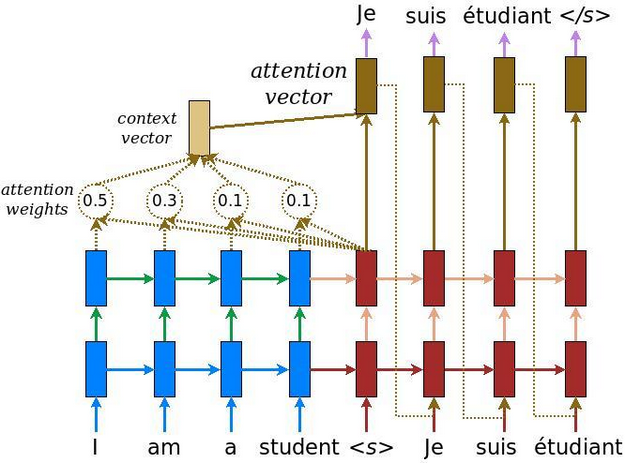  



这里计算score 的方式有一下两种：  

$$\operatorname{score}\left(\boldsymbol{h}_{t}, \overline{\boldsymbol{h}}_{s}\right)=\left\{\begin{array}{ll}
\boldsymbol{h}_{t}^{\top} \boldsymbol{W} \overline{\boldsymbol{h}}_{s} & \text { [Luong's multiplicative style] } \\
\boldsymbol{v}_{a}^{\top} \tanh \left(\boldsymbol{W}_{1} \boldsymbol{h}_{t}+\boldsymbol{W}_{2} \overline{\boldsymbol{h}}_{s}\right) & \text { [Bahdanau's additive style] }
\end{array}\right.$$  

编码器采用 [Bahdanau](https://arxiv.org/pdf/1409.0473.pdf) 注意力，也就是第二种方法进行计算  



- FC = 完全连接（密集）层
- EO = 编码器输出
- H = 隐藏层状态
- X = 解码器输入

以及伪代码：

    score = FC(tanh(FC(EO) + FC(H)))
    # 下边的代码已经提前定义了这里的三个FC，分别是W1， W2，V
    attention weights = softmax(score, axis = 1)。 Softmax 默认被应用于最后一个轴，但是这里我们想将它应用于 第一个轴, 因为分数 （score） 的形状是 (批大小，最大长度，隐藏层大小)。最大长度 （max_length） 是我们的输入的长度。因为我们想为每个输入分配一个权重，所以 softmax 应该用在这个轴上。
    context vector = sum(attention weights * EO, axis = 1)。选择第一个轴的原因同上。
    embedding output = 解码器输入 X 通过一个嵌入层。
    merged vector = concat(embedding output, context vector)
    此合并后的向量随后被传送到 GRU


## Attention

In [56]:
class BahdanauAttention(tf.keras.Model):
    # other attention is LuongAttention
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        # 将W1 W2 V这些参数进行初始化，进行Dense层操作，定义好最终要划分成多少类
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):  # query = decoder_hidden_output, values = encoder_output
        # attention的实际操作中有一个q, v，这里的q和v分别代表的是，解码器每个单元隐藏层的输出(query)和编码器的每个单元的输出(values)
        # 运行的时候查看一下这里为什么需要一个增维的处理，更好的来理解
        # hidden shape == (batch_size, hidden_size) 增维后：
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)  # 是增加了时间步的维度吗
        hidden_with_time_axis = tf.expand_dims(query, 1)

        # 这里的score求的就是图中0.4,0.3，...的分数
        # 分数的形状 == （批大小，最大长度，1）
        # 我们在最后一个轴上得到 1， 因为我们把分数应用于 self.V
        # 在应用 self.V 之前，张量的形状是（批大小，最大长度，单位）
        score = self.V(tf.nn.tanh(self.W1(values) + self.W2(hidden_with_time_axis)))
        # 这个式子中的hidden的值就是

        # 注意力权重 （attention_weights） 的形状 == （批大小，最大长度，1）
        # 对score进行求softmax，得到注意力权重
        attention_weights = tf.nn.softmax(score, axis=1)

        # 上下文向量 （context_vector） 求和之后的形状 == （批大小，隐藏层大小）
        # 使用注意力权重乘以encoder输出的状态变量
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [57]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 35, 1)


## Decoder 

In [58]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        # 对于decoder，一开始的时候的初始化是和encoder基本一样的
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        # 就是这里多了一个全连接层，多带上了一个softmax，进行分类的大小就是词典的大小
        self.fc = tf.keras.layers.Dense(vocab_size)

        # used for attention
        # 进行一个Attention的初始化：将上边的Attention层拿下来进行实例化
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        # 上边实例化之后这里进行计算
        # 首先拿到Attention的输出结果
        # 编码器输出 （enc_output） 的形状 == （批大小，最大长度，隐藏层大小）
        context_vector, attention_weights = self.attention(hidden, enc_output)
        # 上边定义的Attention在这里也就拿到使用，作为进行decoder的一个输入

        # x 在通过嵌入层后的形状 == （批大小，1，嵌入维度）
        # decoder的输入，先进行词向量的一个embedding
        x = self.embedding(x)

        # x 在拼接 （concatenation） 后的形状 == （批大小，1，嵌入维度 + 隐藏层大小）
        # 合并后得到最终的输入
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # 将合并后的向量传送到 GRU
        output, state = self.gru(x)

        # 输出的形状 == （批大小 * 1，隐藏层大小）
        output = tf.reshape(output, (-1, output.shape[2]))

        # 输出的形状 == （批大小，vocab）
        x = self.fc(output)

        return x, state, attention_weights

In [59]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((64, 1)), sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 1596)


## 优化器-定义损失函数

In [63]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

## 使用checkpoints逐步保存模型结果

In [64]:
checkpoint_dir = '/Users/zn-nlp/Documents/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

## train

In [65]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
            # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

            loss += loss_function(targ[:,t], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(targ[:,t], 1)

    # 先拿到一个样本的loss
    batch_loss = (loss / int(targ.shape[1]))
    
    # 拿到一个参数，这都是统一这么写的
    variables = encoder.trainable_variables + decoder.trainable_variables
    
    # 反向求导
    gradients = tape.gradient(loss, variables)
    
    # 使用优化器进行更新
    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [66]:
EPOCHS = 3  # 这里设置的比较小，要不然计算太慢了

for epoch in range(EPOCHS):
    start = time.time()  # 统计时间

    enc_hidden = encoder.initialize_hidden_state()  # 初始化encoder hidden层
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        # 前边做那么多的数据的处理，转换成index，加上什么<start><end>..,最后就是要做成一个数据集
        # 接下来按照batch_size的方式往里边扔
        # 在前边准备的数据集中一个batch一个batch的拿，输入和标签都拿，扔到train_step函数里边，在train_step中就涉及到
        # 的就是那些encoder，decoder的模型，最终的目的是拿到loss，看loss的变化，训练n个epoch，知道loss不发生变化的时候
        # 就可以停止了
        batch_loss = train_step(inp, targ, enc_hidden)
        # 加到总的损失函数里边
        total_loss += batch_loss

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, batch_loss.numpy()))
    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 3.8126
Epoch 1 Loss 3.7446
Time taken for 1 epoch 21.556495666503906 sec

Epoch 2 Batch 0 Loss 5.9183
Epoch 2 Loss 4.1405
Time taken for 1 epoch 1.4408297538757324 sec

Epoch 3 Batch 0 Loss 3.4339
Epoch 3 Loss 3.4637
Time taken for 1 epoch 0.9049327373504639 sec



In [67]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_sentence_english(sentence)

    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_inp,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.index_word[predicted_id] + ' '

        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [68]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [69]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [70]:
# restoring the latest checkpoint in checkpoint_dir
# 在训练和保存模型的时候，可以一个或者几个epoch进行保存，然后随时可以停，这里看着差不多了可以手动停，
# 结束之后就可以通过这个API继续
# 它是从你停止的地方接着训练  那么怎么设置早停
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> politicians do not have permission to <end>
Predicted translation: ह ह ह ह ह ह ह ह ह ह ह ह ह ह ह ह ह ह ह ह ह ह ह ह 


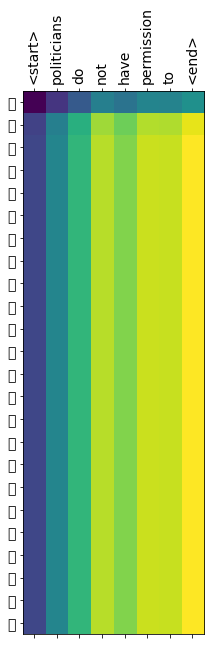

In [71]:
translate(u'politicians do not have permission to')
# 跑的epoch次数太少了

## 代码的工程实现具体的形式：4-1:2:45-> 